<a href="https://colab.research.google.com/github/yeonju73/Image-Matching-System/blob/main/fine_tuning_cnn_ver5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124


## Prepair Dataset

In [3]:
!git clone https://github.com/hbcbh1999/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11745, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11745 (delta 0), reused 0 (delta 0), pack-reused 11742 (from 1)
Receiving objects: 100% (11745/11745), 395.63 MiB | 34.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (11778/11778), done.


In [4]:
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

ImageFolder structure

```
data_dir/Bicycle/xxx.png
data_dir/Bicycle/xxy.png
data_dir/Bicycle/[...]/xxz.png
...
data_dir/Traffic Light/123.png
data_dir/Traffic Light/nsdf3.png
data_dir/Traffic Light/[...]/asd932_.png
```



In [46]:
data_dir = "./recaptcha-dataset/Large"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = 32

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)  # your dataset
num_data = len(image_datasets)
indices = np.arange(num_data)
np.random.shuffle(indices)

train_size = int(num_data*0.8) # 80 퍼센트는 학습, 20 퍼센트는 검증
train_indices = indices[:train_size]
val_indices = indices[train_size:]
train_set = torch.utils.data.Subset(image_datasets, train_indices)
val_set = torch.utils.data.Subset(image_datasets, val_indices)

print('Number of training data:', len(train_set))
print('Number of validation data:', len(val_set))

dataloaders = {'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
                 'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)}

Initializing Datasets and Dataloaders...
Number of training data: 8233
Number of validation data: 2059


In [47]:
def imshow(imgs, title=None):
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


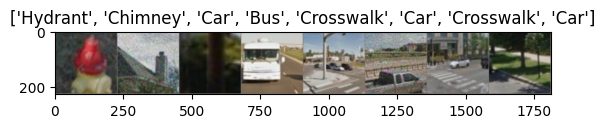

In [48]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


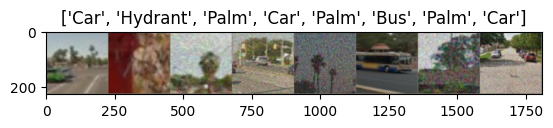

In [49]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [60]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [61]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers -> 각각 4개씩 선언?
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.3)              # ← Dropout 추가
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 16 개 레이어 통과
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        # feature 맵 사이즈를 동일하게 줄여줌
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

In [62]:
model = ResNet_18(image_channels=3, num_classes=10)
summary(model, (3, 224, 224), device='cpu')
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [63]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 파라미터를 학습되지 않게

In [64]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        # Dropout + Linear head 추가
        model_ft.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [70]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet50"

num_classes = 10
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False # 학습을 할 것이기 때문에

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (3, 224, 224), device='cpu')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Train model

In [71]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [72]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [73]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0015, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [74]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.0326 Acc: 0.6676
val Loss: 0.6531 Acc: 0.7887

Epoch 1/14
----------
train Loss: 0.6453 Acc: 0.7916
val Loss: 0.6003 Acc: 0.8086

Epoch 2/14
----------
train Loss: 0.5767 Acc: 0.8136
val Loss: 0.5196 Acc: 0.8295

Epoch 3/14
----------
train Loss: 0.5334 Acc: 0.8255
val Loss: 0.5252 Acc: 0.8422

Epoch 4/14
----------
train Loss: 0.4857 Acc: 0.8402
val Loss: 0.5104 Acc: 0.8344

Epoch 5/14
----------
train Loss: 0.4641 Acc: 0.8471
val Loss: 0.5279 Acc: 0.8349

Epoch 6/14
----------
train Loss: 0.4566 Acc: 0.8498
val Loss: 0.5114 Acc: 0.8407

Epoch 7/14
----------
train Loss: 0.4168 Acc: 0.8626
val Loss: 0.4525 Acc: 0.8572

Epoch 8/14
----------
train Loss: 0.4151 Acc: 0.8595
val Loss: 0.5246 Acc: 0.8320

Epoch 9/14
----------
train Loss: 0.3950 Acc: 0.8695
val Loss: 0.5309 Acc: 0.8320

Epoch 10/14
----------
train Loss: 0.3913 Acc: 0.8705
val Loss: 0.5126 Acc: 0.8485

Epoch 11/14
----------
train Loss: 0.3913 Acc: 0.8699
val Loss: 0.4791 Acc: 0.8553

Ep



```
# 코드로 형식 지정됨
```

## Save the model & features

In [ ]:
# 모델의 웨이트만 저장
# torch.save(model_ft.state_dict(), 'resnet18.pt')

In [ ]:
torch.save(model_ft, 'resnet18_ft.pt')

In [ ]:
model_ft = torch.load('resnet18_ft.pt', weights_only=False)
modules = list(model_ft.children())[:-1]
resnet18_feat = nn.Sequential(*modules)

for p in resnet18_feat.parameters():
    p.requires_grad = False

In [ ]:
# Test
out = resnet18_feat(torch.rand(1, 3, 224, 224).to(device))
print(out.shape)

out = out.view([-1, 512])
print(out.shape)

out = out.detach().cpu().numpy()
print(type(out))

torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
<class 'numpy.ndarray'>


In [ ]:
from tqdm import tqdm

In [ ]:
train_features = []
train_labels = []
val_features = []
val_labels = []

for inputs, labels in tqdm(dataloaders['train']):
  inputs = inputs.to(device)
  h = resnet18_feat(inputs)

  # Eliminate unnecessary dimensions
  h = h.view([-1, 512])

  # Move to 'cpu' & change to 'numpy array'
  h = h.detach().cpu().numpy()

  train_features.append(h)

  # labels
  train_labels.append(labels.detach().cpu().numpy())

for inputs, labels in tqdm(dataloaders['val']):
  inputs = inputs.to(device)
  h = resnet18_feat(inputs)

  # Eliminate unnecessary dimensions
  h = h.view([-1, 512])
  # Move to 'cpu' & change to 'numpy array'
  h = h.detach().cpu().numpy()

  val_features.append(h)

  # labels
  val_labels.append(labels.detach().cpu().numpy())

100%|██████████| 65/65 [00:06<00:00, 10.70it/s]


In [ ]:
train_features = np.concat(train_features, axis=0)
train_labels = np.concat(train_labels, axis=0)
val_features = np.concat(val_features, axis=0)
val_labels = np.concat(val_labels, axis=0)

print(f"Train Features: ({train_features.shape})")
print(f"Train Labels: ({train_labels.shape})")
print(f"Validation Features: ({val_features.shape})")
print(f"Validation Labels: ({val_labels.shape})")

Train Features: ((8233, 512))
Train Labels: ((8233,))
Validation Features: ((2059, 512))
Validation Labels: ((2059,))


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

recaptcha = './recaptcha-dataset/Large/'
labels = ['Bicycle','Bridge','Bus','Car','Chimney',
          'Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light']

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_features, train_labels)

KNeighborsClassifier()

In [ ]:
predict_labels = classifier.predict(val_features)
print(classification_report(val_labels, predict_labels, labels=labels))

               precision    recall  f1-score   support

      Bicycle       0.00      0.00      0.00         0
       Bridge       0.00      0.00      0.00         0
          Bus       0.00      0.00      0.00         0
          Car       0.00      0.00      0.00         0
      Chimney       0.00      0.00      0.00         0
    Crosswalk       0.00      0.00      0.00         0
      Hydrant       0.00      0.00      0.00         0
   Motorcycle       0.00      0.00      0.00         0
         Palm       0.00      0.00      0.00         0
Traffic Light       0.00      0.00      0.00         0

    micro avg       0.00      0.00      0.00         0
    macro avg       0.00      0.00      0.00         0
 weighted avg       0.00      0.00      0.00         0



In [ ]:
predict_labels

array([3, 6, 6, ..., 6, 6, 7])

In [ ]:
neigh_ind = classifier.kneighbors(X=val_features, n_neighbors=10, return_distance=False) # Top-10 results
neigh_labels = np.array(train_labels)[neigh_ind]
print(neigh_labels[:2])

# 숫자를 이름으로 변경
neigh_label_names = [[labels[idx] for idx in topk] for topk in neigh_labels]
print(neigh_label_names[:2])

[[3 3 3 3 3 9 5 3 3 3]
 [6 9 6 6 6 6 6 6 5 2]]
[['Car', 'Car', 'Car', 'Car', 'Car', 'Traffic Light', 'Crosswalk', 'Car', 'Car', 'Car'], ['Hydrant', 'Traffic Light', 'Hydrant', 'Hydrant', 'Hydrant', 'Hydrant', 'Hydrant', 'Hydrant', 'Crosswalk', 'Bus']]
